# DAX Pivot Point Detailed Excursion Study v3
## Fractional Target Reach Probabilities by Opening Zone

**Objective:** Measure probability of reaching fractional targets between pivot levels, conditioned on opening zone.

**Core Concept - ABSOLUTE TARGETS (LOW TO HIGH):**
- ALL ranges measured from LOW to HIGH (e.g., S2→S1, S1→PP, PP→R1, R1→R2)
- Fractional targets: Low + (0.25/0.50/0.75) × (High - Low)
- Example for PP-R1 range: PP, PP+25%, PP+50%, PP+75%, R1
- We measure: Did the day's High/Low reach each of these ABSOLUTE levels?

**Target Labeling (CLEAR):**
- Format: `LEVEL_FRACTION` or `LEVEL`
- Examples:
  - `S2` = Reached S2 level
  - `S2_S1_025` = Reached 25% of S2→S1 range
  - `S2_S1_050` = Reached 50% of S2→S1 range
  - `S1` = Reached S1 level
  - `S1_PP_025` = Reached 25% of S1→PP range
  - `PP` = Reached PP level
  - `PP_R1_050` = Reached 50% of PP→R1 range
  - `R1` = Reached R1 level
  - `R1_R2_075` = Reached 75% of R1→R2 range

**Opening Zones (8 total):**
1. Above_R3
2. R2_R3
3. R1_R2
4. PP_R1
5. S1_PP
6. S2_S1
7. S3_S2
8. Below_S3

**Data:** M5 OHLCV, Jan 2021 - present, RTH only (09:00-17:30 Berlin)

---

## Step 1: Setup and Data Loading

In [1]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20, 14)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 2: Fetch Data and Calculate Pivot Points

In [2]:
print('\n[STEP 2] Fetch M5 Data and Calculate Pivot Points')
print('='*80)

# Get date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = datetime(2021, 1, 1)

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Filter to RTH (09:00-17:30)
df_rth = df[
    (df['hour'] >= 9) & 
    ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))
].copy()

print(f'[OK] RTH filtered: {len(df_rth)} candles')
print(f'Date range: {df_rth.index.min().date()} to {df_rth.index.max().date()}')

2025-12-10 21:10:34,363 - shared.database_connector - INFO - Initializing database connection...
2025-12-10 21:10:34,365 - shared.database_connector - WARNING - CA certificate not found at certs\ca-certificate.crt. Connecting without SSL verification.



[STEP 2] Fetch M5 Data and Calculate Pivot Points


2025-12-10 21:10:35,101 - shared.database_connector - INFO - [OK] Database connection successful
2025-12-10 21:10:35,375 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2020-09-14 22:00:00+00:00 to 2025-11-27 22:55:00+00:00
2025-12-10 21:10:35,376 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2021-01-01 00:00:00, end=2025-11-27 22:55:00+00:00


Fetching M5 data: 2021-01-01 to 2025-11-27


2025-12-10 21:10:38,072 - shared.database_connector - INFO - [OK] Fetched 336793 candles (2021-01-03 22:00:00+00:00 to 2025-11-27 22:55:00+00:00)


[OK] Fetched 336793 M5 candles
[OK] RTH filtered: 130353 candles
Date range: 2021-01-04 to 2025-11-27


## Step 3: Aggregate to Daily and Calculate Pivot Levels

In [3]:
print('\n[STEP 3] Aggregate to Daily and Calculate Pivot Points')
print('='*80)

# Aggregate to daily
daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 50:
        continue
    
    daily_open = day_data.iloc[0]['open']
    daily_high = day_data['high'].max()
    daily_low = day_data['low'].min()
    daily_close = day_data.iloc[-1]['close']
    
    row = {
        'date': date,
        'open': daily_open,
        'high': daily_high,
        'low': daily_low,
        'close': daily_close,
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')

# Calculate previous day OHLC (shifted, no look-ahead)
df_daily['prev_high'] = df_daily['high'].shift(1)
df_daily['prev_low'] = df_daily['low'].shift(1)
df_daily['prev_close'] = df_daily['close'].shift(1)

# Drop first day
df_daily = df_daily[df_daily['prev_close'].notna()].reset_index(drop=True)

print(f'[OK] Valid days: {len(df_daily)}')

# Calculate Standard Floor Pivot Points
df_daily['PP'] = (df_daily['prev_high'] + df_daily['prev_low'] + df_daily['prev_close']) / 3

df_daily['R1'] = (2 * df_daily['PP']) - df_daily['prev_low']
df_daily['S1'] = (2 * df_daily['PP']) - df_daily['prev_high']

df_daily['R2'] = df_daily['PP'] + (df_daily['prev_high'] - df_daily['prev_low'])
df_daily['S2'] = df_daily['PP'] - (df_daily['prev_high'] - df_daily['prev_low'])

df_daily['R3'] = df_daily['prev_high'] + 2 * (df_daily['PP'] - df_daily['prev_low'])
df_daily['S3'] = df_daily['prev_low'] - 2 * (df_daily['prev_high'] - df_daily['PP'])

# Calculate R4/S4 (extended levels)
df_daily['R4'] = df_daily['R3'] + (df_daily['R2'] - df_daily['R1'])
df_daily['S4'] = df_daily['S3'] - (df_daily['S1'] - df_daily['S2'])

print(f'[OK] Pivot points calculated (PP, R1-R4, S1-S4)')
print(f'\nSample (first 5 days):')
print(df_daily[['date', 'open', 'high', 'low', 'PP', 'R1', 'R2', 'S1', 'S2']].head())


[STEP 3] Aggregate to Daily and Calculate Pivot Points
[OK] Aggregated to 1266 trading days
[OK] Valid days: 1265
[OK] Pivot points calculated (PP, R1-R4, S1-S4)

Sample (first 5 days):
         date       open       high        low            PP            R1  \
0  2021-01-05  13703.203  13729.249  13564.799  13715.242333  13839.315667   
1  2021-01-06  13654.257  13920.299  13638.749  13653.412333  13742.025667   
2  2021-01-07  13950.399  14007.399  13913.259  13822.402333  14006.055667   
3  2021-01-08  14097.297  14099.289  14004.759  13959.935667  14006.612333   
4  2021-01-11  13946.299  14001.297  13804.267  14055.949000  14107.139000   

             R2            S1            S2  
0  14030.472333  13524.085667  13400.012333  
1  13817.862333  13577.575667  13488.962333  
2  14103.952333  13724.505667  13540.852333  
3  14054.075667  13912.472333  13865.795667  
4  14150.479000  14012.609000  13961.419000  


## Step 4: Classify Opening Zone

In [4]:
print('\n[STEP 4] Classify Opening Zone')
print('='*80)

def classify_opening_zone(row):
    """Classify where the 09:00 open occurred relative to pivot levels."""
    open_price = row['open']
    
    if open_price > row['R3']:
        return 'Above_R3'
    elif row['R2'] < open_price <= row['R3']:
        return 'R2_R3'
    elif row['R1'] < open_price <= row['R2']:
        return 'R1_R2'
    elif row['PP'] < open_price <= row['R1']:
        return 'PP_R1'
    elif row['S1'] < open_price <= row['PP']:
        return 'S1_PP'
    elif row['S2'] < open_price <= row['S1']:
        return 'S2_S1'
    elif row['S3'] < open_price <= row['S2']:
        return 'S3_S2'
    else:  # open_price <= S3
        return 'Below_S3'

df_daily['opening_zone'] = df_daily.apply(classify_opening_zone, axis=1)

print(f'[OK] Opening zones classified')
print(f'\nOpening Zone Distribution:')
zone_counts = df_daily['opening_zone'].value_counts()
zone_order = ['Above_R3', 'R2_R3', 'R1_R2', 'PP_R1', 'S1_PP', 'S2_S1', 'S3_S2', 'Below_S3']
for zone in zone_order:
    count = zone_counts.get(zone, 0)
    pct = count / len(df_daily) * 100 if len(df_daily) > 0 else 0
    print(f'  {zone:12} {count:4d} days ({pct:5.1f}%)')


[STEP 4] Classify Opening Zone
[OK] Opening zones classified

Opening Zone Distribution:
  Above_R3       38 days (  3.0%)
  R2_R3          71 days (  5.6%)
  R1_R2         182 days ( 14.4%)
  PP_R1         418 days ( 33.0%)
  S1_PP         322 days ( 25.5%)
  S2_S1         126 days ( 10.0%)
  S3_S2          68 days (  5.4%)
  Below_S3       40 days (  3.2%)


## Step 5: Calculate ABSOLUTE Fractional Targets (All LOW→HIGH)

**Key Principle:** ALL targets are absolute price levels, measured LOW→HIGH.

**Complete Target List (Bottom to Top):**
- S4
- S3_S4_025, S3_S4_050, S3_S4_075
- S3
- S2_S3_025, S2_S3_050, S2_S3_075
- S2
- S1_S2_025, S1_S2_050, S1_S2_075
- S1
- S1_PP_025, S1_PP_050, S1_PP_075
- PP
- PP_R1_025, PP_R1_050, PP_R1_075
- R1
- R1_R2_025, R1_R2_050, R1_R2_075
- R2
- R2_R3_025, R2_R3_050, R2_R3_075
- R3
- R3_R4_025, R3_R4_050, R3_R4_075
- R4

In [5]:
print('\n[STEP 5] Calculate ABSOLUTE Fractional Targets (LOW to HIGH)')
print('='*80)

def calculate_absolute_targets(row):
    """
    Calculate ALL fractional targets as absolute price levels.
    Every range measured LOW to HIGH.
    """
    targets = {}
    
    # S4 level
    targets['S4'] = row['S4']
    
    # S3-S4 range (low=S4, high=S3)
    dist = row['S3'] - row['S4']
    targets['S3_S4_025'] = row['S4'] + 0.25 * dist
    targets['S3_S4_050'] = row['S4'] + 0.50 * dist
    targets['S3_S4_075'] = row['S4'] + 0.75 * dist
    
    # S3 level
    targets['S3'] = row['S3']
    
    # S2-S3 range (low=S3, high=S2)
    dist = row['S2'] - row['S3']
    targets['S2_S3_025'] = row['S3'] + 0.25 * dist
    targets['S2_S3_050'] = row['S3'] + 0.50 * dist
    targets['S2_S3_075'] = row['S3'] + 0.75 * dist
    
    # S2 level
    targets['S2'] = row['S2']
    
    # S1-S2 range (low=S2, high=S1)
    dist = row['S1'] - row['S2']
    targets['S1_S2_025'] = row['S2'] + 0.25 * dist
    targets['S1_S2_050'] = row['S2'] + 0.50 * dist
    targets['S1_S2_075'] = row['S2'] + 0.75 * dist
    
    # S1 level
    targets['S1'] = row['S1']
    
    # S1-PP range (low=S1, high=PP)
    dist = row['PP'] - row['S1']
    targets['S1_PP_025'] = row['S1'] + 0.25 * dist
    targets['S1_PP_050'] = row['S1'] + 0.50 * dist
    targets['S1_PP_075'] = row['S1'] + 0.75 * dist
    
    # PP level
    targets['PP'] = row['PP']
    
    # PP-R1 range (low=PP, high=R1)
    dist = row['R1'] - row['PP']
    targets['PP_R1_025'] = row['PP'] + 0.25 * dist
    targets['PP_R1_050'] = row['PP'] + 0.50 * dist
    targets['PP_R1_075'] = row['PP'] + 0.75 * dist
    
    # R1 level
    targets['R1'] = row['R1']
    
    # R1-R2 range (low=R1, high=R2)
    dist = row['R2'] - row['R1']
    targets['R1_R2_025'] = row['R1'] + 0.25 * dist
    targets['R1_R2_050'] = row['R1'] + 0.50 * dist
    targets['R1_R2_075'] = row['R1'] + 0.75 * dist
    
    # R2 level
    targets['R2'] = row['R2']
    
    # R2-R3 range (low=R2, high=R3)
    dist = row['R3'] - row['R2']
    targets['R2_R3_025'] = row['R2'] + 0.25 * dist
    targets['R2_R3_050'] = row['R2'] + 0.50 * dist
    targets['R2_R3_075'] = row['R2'] + 0.75 * dist
    
    # R3 level
    targets['R3'] = row['R3']
    
    # R3-R4 range (low=R3, high=R4)
    dist = row['R4'] - row['R3']
    targets['R3_R4_025'] = row['R3'] + 0.25 * dist
    targets['R3_R4_050'] = row['R3'] + 0.50 * dist
    targets['R3_R4_075'] = row['R3'] + 0.75 * dist
    
    # R4 level
    targets['R4'] = row['R4']
    
    return targets

# Calculate targets for each day
df_daily['targets'] = df_daily.apply(calculate_absolute_targets, axis=1)

print(f'[OK] Absolute fractional targets calculated (ALL ranges LOW to HIGH)')
print(f'\nExample (first day):' )
example = df_daily.iloc[0]
print(f"  Date: {example['date']}")
print(f"  Open: {example['open']:.2f}")
print(f"  High: {example['high']:.2f}, Low: {example['low']:.2f}")
print(f"  Zone: {example['opening_zone']}")
print(f"\n  Sample targets:")
sample_keys = ['S2', 'S1_S2_050', 'S1', 'S1_PP_050', 'PP', 'PP_R1_050', 'R1', 'R1_R2_050', 'R2']
for key in sample_keys:
    if key in example['targets']:
        print(f"    {key:15} = {example['targets'][key]:.2f}")


[STEP 5] Calculate ABSOLUTE Fractional Targets (LOW to HIGH)
[OK] Absolute fractional targets calculated (ALL ranges LOW to HIGH)

Example (first day):
  Date: 2021-01-05
  Open: 13703.20
  High: 13729.25, Low: 13564.80
  Zone: S1_PP

  Sample targets:
    S2              = 13400.01
    S1_S2_050       = 13462.05
    S1              = 13524.09
    S1_PP_050       = 13619.66
    PP              = 13715.24
    PP_R1_050       = 13777.28
    R1              = 13839.32
    R1_R2_050       = 13934.89
    R2              = 14030.47


## Step 6: Measure Target Reach (High vs Low)

In [6]:
print('\n[STEP 6] Measure Target Reach')
print('='*80)

def measure_reach(row):
    """
    Check which targets were reached during the day.
    High >= target (reached from below)
    Low <= target (reached from above)
    """
    targets = row['targets']
    high = row['high']
    low = row['low']
    
    reached = {}
    
    for key, price in targets.items():
        # Did we reach this level?
        # Reached = either High touched from below OR Low touched from above
        reached[key] = (high >= price) and (low <= price)
        # Note: This checks if price was WITHIN the day's range
        # For more accurate: high >= price means "reached going up"
        # For simplicity: check if level was touched at all
        
        # Actually, let's be more precise:
        # If target is BELOW open: did Low reach it? (low <= target)
        # If target is ABOVE open: did High reach it? (high >= target)
        # If target is within [low, high]: automatically reached
        
        reached[key] = (low <= price <= high)
    
    return reached

# Measure reach for each day
df_daily['reach'] = df_daily.apply(measure_reach, axis=1)

print(f'[OK] Target reach measured for all days')


[STEP 6] Measure Target Reach
[OK] Target reach measured for all days


## Step 7: Analyze by Zone (Probability Tables)

In [7]:
print('\n[STEP 7] Generate Probability Tables by Opening Zone')
print('='*80)

# Define target order (bottom to top)
target_order = [
    'S4',
    'S3_S4_025', 'S3_S4_050', 'S3_S4_075',
    'S3',
    'S2_S3_025', 'S2_S3_050', 'S2_S3_075',
    'S2',
    'S1_S2_025', 'S1_S2_050', 'S1_S2_075',
    'S1',
    'S1_PP_025', 'S1_PP_050', 'S1_PP_075',
    'PP',
    'PP_R1_025', 'PP_R1_050', 'PP_R1_075',
    'R1',
    'R1_R2_025', 'R1_R2_050', 'R1_R2_075',
    'R2',
    'R2_R3_025', 'R2_R3_050', 'R2_R3_075',
    'R3',
    'R3_R4_025', 'R3_R4_050', 'R3_R4_075',
    'R4',
]

def analyze_zone(df, zone_name):
    """
    Analyze a specific opening zone and return probability table.
    """
    zone_data = df[df['opening_zone'] == zone_name].copy()
    
    if len(zone_data) < 5:
        return None
    
    n = len(zone_data)
    
    # Calculate probabilities for all targets
    results = []
    for target_key in target_order:
        count = sum(row['reach'].get(target_key, False) for _, row in zone_data.iterrows())
        prob = count / n if n > 0 else 0
        
        results.append({
            'target': target_key,
            'count': count,
            'probability': prob,
        })
    
    return pd.DataFrame(results)

# Analyze each zone
zone_order_list = ['Above_R3', 'R2_R3', 'R1_R2', 'PP_R1', 'S1_PP', 'S2_S1', 'S3_S2', 'Below_S3']

zone_results = {}

for zone in zone_order_list:
    zone_df = analyze_zone(df_daily, zone)
    if zone_df is not None:
        zone_results[zone] = zone_df
        
        print(f'\n[{zone}] (N = {len(df_daily[df_daily["opening_zone"] == zone])} days)')
        print('='*80)
        print(f'{"Target":<20} {"Count":>8} {"Probability":>12}')
        print('-'*80)
        
        # Only show targets with some activity (>0% or <100%)
        interesting = zone_df[(zone_df['probability'] > 0.01) & (zone_df['probability'] < 0.99)]
        if len(interesting) > 0:
            for _, row in interesting.iterrows():
                print(f'{row["target"]:<20} {row["count"]:>8d} {row["probability"]:>11.0%}')
        else:
            print('  [All targets either 0% or 100% - zone too wide or too narrow]')


[STEP 7] Generate Probability Tables by Opening Zone

[Above_R3] (N = 38 days)
Target                  Count  Probability
--------------------------------------------------------------------------------
S4                          1          3%
S3_S4_025                   1          3%
S3_S4_050                   1          3%
S3_S4_075                   1          3%
S3                          2          5%
S2_S3_025                   2          5%
S2_S3_050                   2          5%
S2_S3_075                   3          8%
S2                          5         13%
S1_S2_025                   6         16%
S1_S2_050                   7         18%
S1_S2_075                   7         18%
S1                          8         21%
S1_PP_025                   8         21%
S1_PP_050                   8         21%
S1_PP_075                   8         21%
PP                          8         21%
PP_R1_025                   8         21%
PP_R1_050                  10         26

## Step 8: Focused Analysis - Key Zones Only

In [8]:
print('\n[STEP 8] Focused Analysis - Key Zones')
print('='*80)

# For each zone, show only relevant targets (nearby levels)
zone_relevant_targets = {
    'PP_R1': ['S1', 'S1_PP_025', 'S1_PP_050', 'S1_PP_075', 'PP', 'PP_R1_025', 'PP_R1_050', 'PP_R1_075', 'R1', 'R1_R2_025', 'R1_R2_050', 'R1_R2_075', 'R2'],
    'S1_PP': ['S2', 'S1_S2_025', 'S1_S2_050', 'S1_S2_075', 'S1', 'S1_PP_025', 'S1_PP_050', 'S1_PP_075', 'PP', 'PP_R1_025', 'PP_R1_050', 'PP_R1_075', 'R1'],
    'R1_R2': ['PP', 'PP_R1_025', 'PP_R1_050', 'PP_R1_075', 'R1', 'R1_R2_025', 'R1_R2_050', 'R1_R2_075', 'R2', 'R2_R3_025', 'R2_R3_050', 'R2_R3_075', 'R3'],
    'S2_S1': ['S3', 'S2_S3_025', 'S2_S3_050', 'S2_S3_075', 'S2', 'S1_S2_025', 'S1_S2_050', 'S1_S2_075', 'S1', 'S1_PP_025', 'S1_PP_050', 'S1_PP_075', 'PP'],
}

for zone in ['PP_R1', 'S1_PP', 'R1_R2', 'S2_S1']:
    if zone in zone_results:
        zone_df = zone_results[zone]
        relevant = zone_df[zone_df['target'].isin(zone_relevant_targets[zone])].copy()
        
        print(f'\n[{zone}] Relevant Targets (N = {len(df_daily[df_daily["opening_zone"] == zone])} days)')
        print('='*80)
        print(f'{"Target":<20} {"Count":>8} {"Probability":>12}')
        print('-'*80)
        
        for _, row in relevant.iterrows():
            print(f'{row["target"]:<20} {row["count"]:>8d} {row["probability"]:>11.0%}')


[STEP 8] Focused Analysis - Key Zones

[PP_R1] Relevant Targets (N = 418 days)
Target                  Count  Probability
--------------------------------------------------------------------------------
S1                         97         23%
S1_PP_025                 119         28%
S1_PP_050                 153         37%
S1_PP_075                 191         46%
PP                        248         59%
PP_R1_025                 299         72%
PP_R1_050                 325         78%
PP_R1_075                 318         76%
R1                        270         65%
R1_R2_025                 223         53%
R1_R2_050                 174         42%
R1_R2_075                 137         33%
R2                        111         27%

[S1_PP] Relevant Targets (N = 322 days)
Target                  Count  Probability
--------------------------------------------------------------------------------
S2                         83         26%
S1_S2_025                 101         31%
S

## Step 9: Visualization


[STEP 9] Visualizations


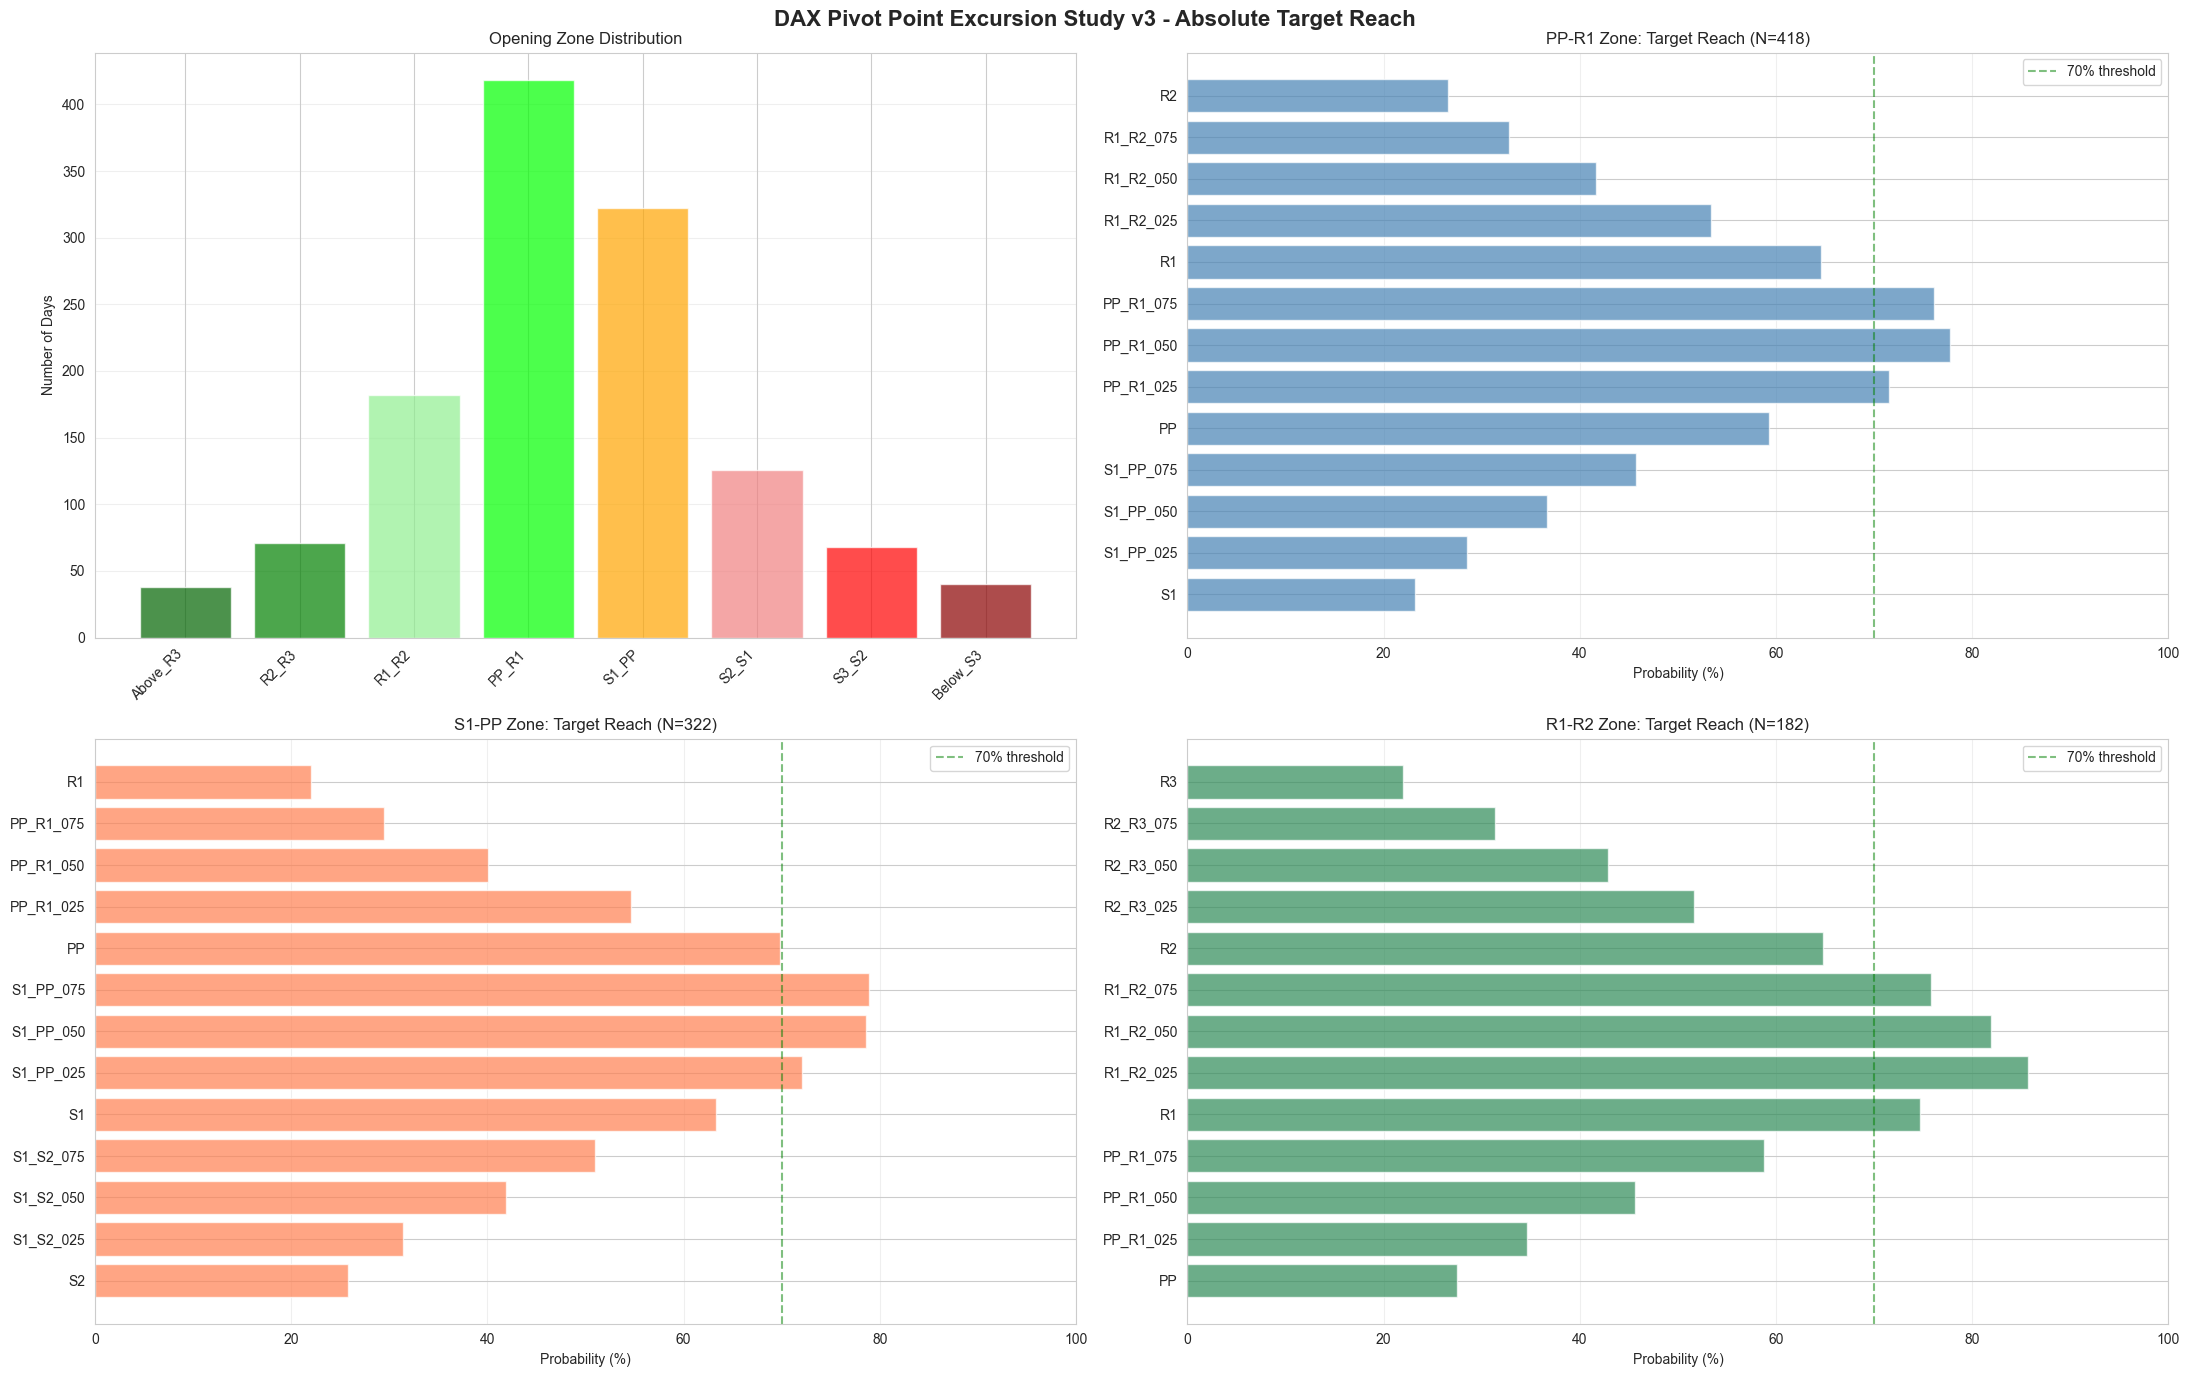

[OK] Visualizations created


In [9]:
print('\n[STEP 9] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(22, 14))
fig.suptitle('DAX Pivot Point Excursion Study v3 - Absolute Target Reach', fontsize=16, fontweight='bold')

# Plot 1: Zone distribution
ax = axes[0, 0]
zone_counts = df_daily['opening_zone'].value_counts().reindex(zone_order_list, fill_value=0)
colors = ['darkgreen', 'green', 'lightgreen', 'lime', 'orange', 'lightcoral', 'red', 'darkred']
ax.bar(range(len(zone_counts)), zone_counts.values, color=colors, alpha=0.7)
ax.set_xticks(range(len(zone_counts)))
ax.set_xticklabels(zone_counts.index, rotation=45, ha='right')
ax.set_ylabel('Number of Days')
ax.set_title('Opening Zone Distribution')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: PP_R1 zone - relevant targets
ax = axes[0, 1]
if 'PP_R1' in zone_results:
    zone_df = zone_results['PP_R1']
    relevant = zone_df[zone_df['target'].isin(zone_relevant_targets['PP_R1'])].copy()
    if len(relevant) > 0:
        ax.barh(relevant['target'], relevant['probability'] * 100, color='steelblue', alpha=0.7)
        ax.set_xlabel('Probability (%)')
        ax.set_title(f'PP-R1 Zone: Target Reach (N={len(df_daily[df_daily["opening_zone"] == "PP_R1"])})')
        ax.set_xlim([0, 100])
        ax.axvline(70, color='green', linestyle='--', alpha=0.5, label='70% threshold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.legend()

# Plot 3: S1_PP zone - relevant targets
ax = axes[1, 0]
if 'S1_PP' in zone_results:
    zone_df = zone_results['S1_PP']
    relevant = zone_df[zone_df['target'].isin(zone_relevant_targets['S1_PP'])].copy()
    if len(relevant) > 0:
        ax.barh(relevant['target'], relevant['probability'] * 100, color='coral', alpha=0.7)
        ax.set_xlabel('Probability (%)')
        ax.set_title(f'S1-PP Zone: Target Reach (N={len(df_daily[df_daily["opening_zone"] == "S1_PP"])})')
        ax.set_xlim([0, 100])
        ax.axvline(70, color='green', linestyle='--', alpha=0.5, label='70% threshold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.legend()

# Plot 4: R1_R2 zone - relevant targets
ax = axes[1, 1]
if 'R1_R2' in zone_results:
    zone_df = zone_results['R1_R2']
    relevant = zone_df[zone_df['target'].isin(zone_relevant_targets['R1_R2'])].copy()
    if len(relevant) > 0:
        ax.barh(relevant['target'], relevant['probability'] * 100, color='seagreen', alpha=0.7)
        ax.set_xlabel('Probability (%)')
        ax.set_title(f'R1-R2 Zone: Target Reach (N={len(df_daily[df_daily["opening_zone"] == "R1_R2"])})')
        ax.set_xlim([0, 100])
        ax.axvline(70, color='green', linestyle='--', alpha=0.5, label='70% threshold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.legend()

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 10: Summary and Export

In [10]:
print('\n[STEP 10] Summary and Export')
print('='*80)

print(f'''
[DAX PIVOT POINT EXCURSION STUDY v3 - SUMMARY]

Data Period: {df_daily["date"].min()} to {df_daily["date"].max()}
Total Trading Days: {len(df_daily)}

METHODOLOGY:
- ALL targets are ABSOLUTE price levels (LOW to HIGH)
- Fractional targets: Low + (0.25/0.50/0.75) × (High - Low)
- Example: S1_PP_050 = S1 + 50% of (PP - S1)
- Measured: Did day's range [Low, High] include this level?

KEY FINDINGS:
''')

# Find high-probability targets (>70%)
high_prob_found = False

for zone in zone_order_list:
    if zone in zone_results:
        zone_df = zone_results[zone]
        n = len(df_daily[df_daily['opening_zone'] == zone])
        
        strong = zone_df[(zone_df['probability'] > 0.70) & (zone_df['probability'] < 0.99)]
        
        if len(strong) > 0:
            high_prob_found = True
            print(f'\n{zone} (N={n}): High-probability targets (>70%)')
            for _, row in strong.iterrows():
                print(f'  {row["target"]:<20} {row["probability"]:>6.0%}')

if not high_prob_found:
    print('\n[NO TARGETS > 70%] Check moderate range (60-70%)')

# Export summary
summary_rows = []
for zone in zone_order_list:
    if zone in zone_results:
        zone_df = zone_results[zone].copy()
        zone_df['opening_zone'] = zone
        zone_df['n_days'] = len(df_daily[df_daily['opening_zone'] == zone])
        summary_rows.append(zone_df)

if len(summary_rows) > 0:
    df_summary = pd.concat(summary_rows, ignore_index=True)
    df_summary = df_summary[['opening_zone', 'n_days', 'target', 'count', 'probability']]
    
    # Filter to interesting range
    interesting = df_summary[(df_summary['probability'] > 0.05) & (df_summary['probability'] < 0.95)]
    
    print(f'\n\nTop 20 most actionable targets (5-95% range):')
    print('='*80)
    
    # Sort by closeness to 50-70% (most actionable)
    interesting['score'] = interesting['probability'].apply(lambda x: abs(x - 0.65))
    top_20 = interesting.nlargest(20, 'probability')[['opening_zone', 'target', 'n_days', 'probability']]
    print(top_20.to_string(index=False))

print('\n[COMPLETE] Analysis finished')
print('='*80)


[STEP 10] Summary and Export

[DAX PIVOT POINT EXCURSION STUDY v3 - SUMMARY]

Data Period: 2021-01-05 to 2025-11-27
Total Trading Days: 1265

METHODOLOGY:
- ALL targets are ABSOLUTE price levels (LOW to HIGH)
- Fractional targets: Low + (0.25/0.50/0.75) × (High - Low)
- Example: S1_PP_050 = S1 + 50% of (PP - S1)
- Measured: Did day's range [Low, High] include this level?

KEY FINDINGS:


Above_R3 (N=38): High-probability targets (>70%)
  R3                      74%
  R3_R4_025               79%
  R3_R4_050               84%
  R3_R4_075               76%
  R4                      76%

R2_R3 (N=71): High-probability targets (>70%)
  R2                      77%
  R2_R3_025               82%
  R2_R3_050               77%
  R2_R3_075               72%

R1_R2 (N=182): High-probability targets (>70%)
  R1                      75%
  R1_R2_025               86%
  R1_R2_050               82%
  R1_R2_075               76%

PP_R1 (N=418): High-probability targets (>70%)
  PP_R1_025               